## TIME SERIES ANALYSIS OF S&P ANALYSIS

In [3]:
import pandas as pd

In [4]:
sp500 = pd.read_csv("D:\Programming\Datasets\sp500.csv")
sp500.head()

,GSPC.Close
0,1455.219971
1,1399.420044
2,1402.109985
3,1403.449951
4,1441.469971


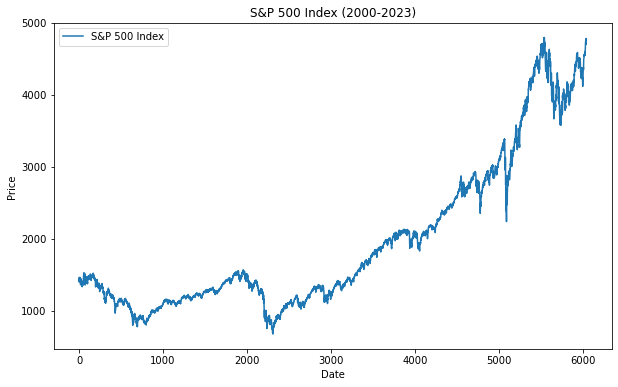

In [5]:
import matplotlib.pyplot as plt

# Plot the closing prices of S&P 500
plt.figure(figsize=(10,6))
plt.plot(sp500['GSPC.Close'], label='S&P 500 Index')
plt.title('S&P 500 Index (2000-2023)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [6]:
# Stationarity Check (Augmented Dickey-Fuller Test)
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test for stationarity
result = adfuller(sp500["GSPC.Close"])

# Extract test statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation
if result[1] < 0.05:
    print("The series is stationary")
else:
    print("The series is non-stationary")


ADF Statistic: 1.5435305158227977
p-value: 0.9976778735039675
The series is non-stationary


### Differencing for Stationarity
If the data is non-stationary, we will apply differencing.

In [7]:
# First-order differencing to make the series stationary
sp500['Close_diff'] = sp500["GSPC.Close"].diff().dropna()

# Recheck stationarity
result = adfuller(sp500['Close_diff'].dropna())
print(f'ADF Statistic (Differenced): {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic (Differenced): -15.430369363601576
p-value: 2.9539685004411226e-28


### 4. ARIMA Model Identification
#### 4.1 Plotting ACF and PACF (AutoCorrelation and Partial AutoCorrelation)
To identify the appropriate p and q values, we plot the ACF and PACF.

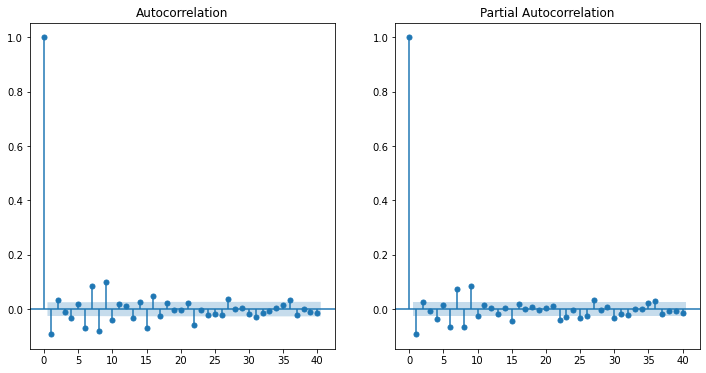

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(sp500['Close_diff'].dropna(), lags=40, ax=plt.gca())

plt.subplot(122)
plot_pacf(sp500['Close_diff'].dropna(), lags=40, ax=plt.gca())

plt.show()


By examining the ACF and PACF plots, you can choose the appropriate values for p (AR) and q (MA).

- p is usually chosen based on the PACF plot, where the lag after which the PACF cuts off is the potential value for p.
- q is chosen based on the ACF plot, where the lag after which the ACF cuts off is the potential value for q.

### 4.2 Model Selection
After visualizing the ACF and PACF plots, you can propose values for p, d, and q. For example, let’s choose p=1, d=1, and q=1 as a simple starting point.

### 5. Model Fitting
##### 5.1 Fit the ARIMA Model

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(sp500["GSPC.Close"], order=(1,1,1))  # ARIMA(p,d,q)
model_fit = model.fit()

# Display the summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             GSPC.Close   No. Observations:                 6037
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -28030.703
Date:                Tue, 12 Nov 2024   AIC                          56067.406
Time:                        17:20:01   BIC                          56087.522
Sample:                             0   HQIC                         56074.390
                               - 6037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3107      0.044     -6.995      0.000      -0.398      -0.224
ma.L1          0.2206      0.046      4.768      0.000       0.130       0.311
sigma2       632.5029      4.104    154.109      0.0

This will fit an ARIMA(1,1,1) model to the data. The summary will give you the estimated coefficients, AIC, and other important statistics.

#### 5.2 Model Diagnostics
You should check the residuals to ensure they are white noise.

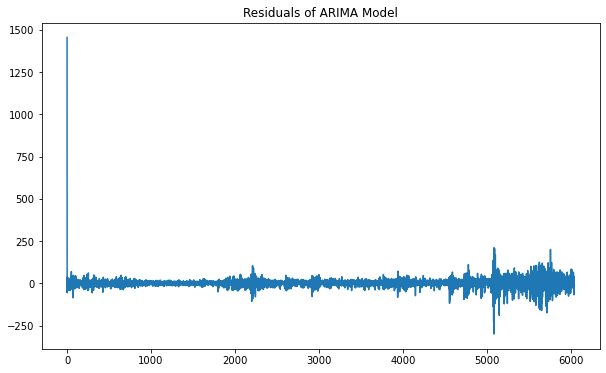

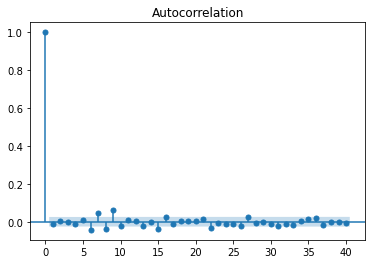

In [10]:
# Plot residuals
plt.figure(figsize=(10,6))
plt.plot(model_fit.resid)
plt.title('Residuals of ARIMA Model')
plt.show()

# Check for autocorrelation in residuals
plot_acf(model_fit.resid, lags=40)
plt.show()


If there is no significant autocorrelation in the residuals, the model is well-fitted.

### 6. Model Evaluation
#### 6.1 Forecasting

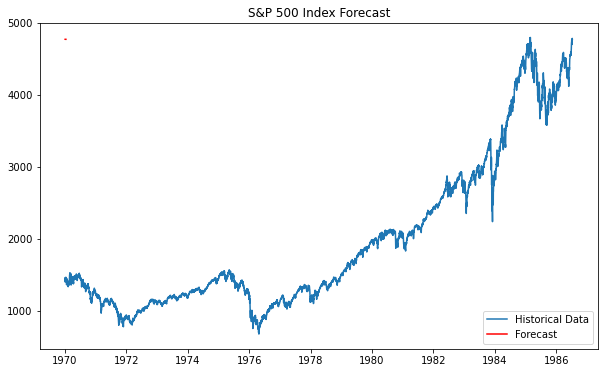

In [11]:
# Forecast the next 10 days
forecast = model_fit.forecast(steps=10)

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(sp500["GSPC.Close"], label='Historical Data')
plt.plot(pd.date_range(sp500.index[-1], periods=11, freq='D')[1:], forecast, label='Forecast', color='red')
plt.title('S&P 500 Index Forecast')
plt.legend()
plt.show()


This will forecast the next 10 data points (you can change the number of steps based on your requirement).

#### 6.2 Performance Metrics

In [12]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for the forecast
rmse = mean_squared_error(sp500["GSPC.Close"][-10:], forecast, squared=False)
print(f'RMSE: {rmse}')


RMSE: 31.591196756744765


### 7. Hypothesis Testing
For stationarity, you’ve already performed the ADF test. For residual autocorrelation, you can use the Ljung-Box test.

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test for residual autocorrelation
lb_test = acorr_ljungbox(model_fit.resid, lags=10)
print(lb_test)


(array([ 1.05262426,  1.12130566,  1.20620534,  2.07080492,  2.78669401,
       14.03811556, 25.55067781, 33.64590769, 56.23518299, 58.63609872]), array([3.04903469e-01, 5.70836282e-01, 7.51516403e-01, 7.22737718e-01,
       7.32830366e-01, 2.92132779e-02, 6.05744509e-04, 4.70875413e-05,
       7.07780011e-09, 6.55965233e-09]))


c:\Users\OKUKU\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [14]:
from scipy.stats import shapiro

# Extract residuals from the fitted model
residuals = model_fit.resid

# Perform the Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic}')
print(f'Shapiro-Wilk p-value: {shapiro_test.pvalue}')

# Interpretation
if shapiro_test.pvalue > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")


Shapiro-Wilk Test Statistic: 0.5881674289703369
Shapiro-Wilk p-value: 0.0
Residuals do not appear to be normally distributed (reject H0).


c:\Users\OKUKU\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


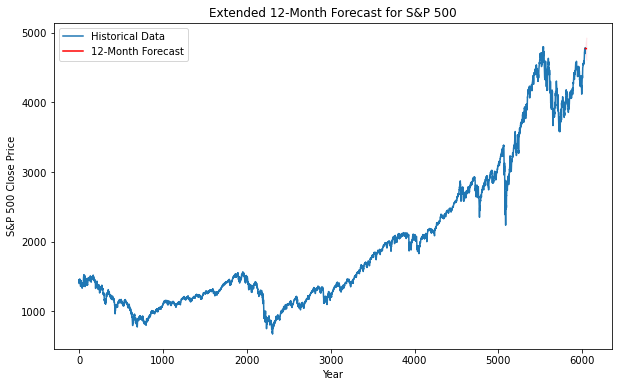

In [15]:
# Forecast for 12 months (adjust `steps` for longer or shorter forecasts)
forecast_extended = model_fit.get_forecast(steps=12)
forecast_ci_extended = forecast_extended.conf_int()

# Plot the extended forecast
plt.figure(figsize=(10, 6))
plt.plot(sp500["GSPC.Close"], label="Historical Data")
plt.plot(forecast_extended.predicted_mean, color='red', label="12-Month Forecast")
plt.fill_between(forecast_ci_extended.index, forecast_ci_extended.iloc[:, 0], forecast_ci_extended.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Extended 12-Month Forecast for S&P 500")
plt.xlabel("Year")
plt.ylabel("S&P 500 Close Price")
plt.legend()
plt.show()


In [18]:
import numpy as np

# Assuming a known future period (e.g., using the last 12 months for testing)
# Adjust this if you have actual test data for forecast comparison
test_data = sp500["GSPC.Close"][-12:]  # Replace with the actual test set if available
forecast_values = forecast_extended.predicted_mean

# Manually calculate MAPE
mape = np.mean(np.abs((test_data - forecast_values) / test_data)) * 100
print(f'MAPE: {mape:.2f}%')


MAPE: nan%
